This Jupyter notebook revisits the [dwave-examples](https://github.com/dwave-examples) /**[antenna-selection](https://github.com/dwave-examples/antenna-selection)** available on D-Wave github and described in the [D-Wave Webinar | How to Use the Ocean Tools Suite for Quantum Programming](https://youtu.be/ckJ59gsFllU).

The main goal here is to explicetely construct the qubo matrix Q. In contrast, the QUBO matrix is not explicitely given in the antenna.py file in the [dwave-examples](https://github.com/dwave-examples) /**[antenna-selection](https://github.com/dwave-examples/antenna-selection)** although it is calculated "behind the scene" as pointed out in the [D-Wave Webinar | How to Use the Ocean Tools Suite for Quantum Programming](https://youtu.be/ckJ59gsFllU) video around 26.16. The implementation below is equivalent to the behind the scene construction happening in [dwave-networkx](https://github.com/dwavesystems/dwave-networkx) / [dwave_networkx](https://github.com/dwavesystems/dwave-networkx/tree/main/dwave_networkx) / [algorithms](https://github.com/dwavesystems/dwave-networkx/tree/main/dwave_networkx/algorithms) / [independent_set.py](https://github.com/dwavesystems/dwave-networkx/blob/main/dwave_networkx/algorithms/independent_set.py).



In addition, simulated annealing sampler is used. This can be handy is the user does not want to use up some of the time on the quantum annealer (if she or he gets a free minute) to run simple "hello world" type programs.

# 1. Formulation

In [1]:
import neal
sampler = neal.SimulatedAnnealingSampler()

In [2]:
vertices = {1,2,3,4,5,6,7} # antennas
edges = { (1,2),(1,3),(2,3),(3,4),(3,5),(4,5),(4,6),(5,6),(6,7) }
lagrange = 2

We want to find the largest set of (antenna) locations possible. The binary variable $x_{i}$ represents antenna $i$. It is 0 if antenna $i$ is selected, 0 otherwise. We want to maximize:
$$
\sum_{i} x_{i}
$$
which is equivalent to minimizing:
$$
-\sum_{i} x_{i}
$$
The quantum annealer seeks to minimize the cost function (if not other optional parameter indicates otherwise).

In [3]:
Q = {}
for i in vertices:
    Q[(i,i)] = -1.

The constraint here is to avoid antenna interferences, no selected antenna should be connected to a neighbor (no edges between subsets, at 22.32 in [video](https://youtu.be/ckJ59gsFllU)). This is achieved with minimizing the term:
$$
\sum_{(u,v)\in E} x_{u} x_{v}
$$

In [4]:
for i in range(1,8):
    for j in range(1,8):
        if j <= i:
            continue
        if (i,j) in edges:
            Q[(i,j)] = 1.*lagrange

In [5]:
def print_qubo(qubo):
    vn = { k[0] for k in qubo.keys() } # variable numbers
    s = '     '
    for i in vn:
        s += "{:4d} ".format(i)
    print(s)
    
    for i in vn:
        print( "{:4d} ".format(i), end='' )
        for j in vn:
            if (i,j) in qubo.keys():
                print( "{: 4.1f} ".format( qubo[(i,j)] ), end='' )
            else:
                print( "   _ ", end='' )
        print('\n')

In [6]:
print_qubo(Q)

        1    2    3    4    5    6    7 
   1 -1.0  2.0  2.0    _    _    _    _ 

   2    _ -1.0  2.0    _    _    _    _ 

   3    _    _ -1.0  2.0  2.0    _    _ 

   4    _    _    _ -1.0  2.0  2.0    _ 

   5    _    _    _    _ -1.0  2.0    _ 

   6    _    _    _    _    _ -1.0  2.0 

   7    _    _    _    _    _    _ -1.0 



# 2. Solve problem with simulated annealing

In [7]:
#==============================================================================
# Simulated annealing:
#==============================================================================
numruns = 100 # 10000 # max
numsweeps = 100 # (int, optional, default=1000) – Number of sweeps or steps.
sampler = neal.SimulatedAnnealingSampler()

response = sampler.sample_qubo(Q,num_reads=numruns,num_sweeps=numsweeps)

In [8]:
response.first

Sample(sample={1: 1, 2: 0, 3: 0, 4: 1, 5: 0, 6: 0, 7: 1}, energy=-3.0, num_occurrences=1)

In [9]:
sample = response.first.sample

In [10]:
solution = [v for v in sample.values()]

In [11]:
solution

[1, 0, 0, 1, 0, 0, 1]

In [12]:
solution2 = [ i+1 for i,si in enumerate(solution) if si==1 ]

In [13]:
solution2

[1, 4, 7]

In [14]:
## import networkx for graph tools
import networkx as nx

## import matplotlib.pyplot to draw graphs on screen
import matplotlib.pyplot as plt

In [15]:
## Create empty graph
G = nx.Graph()

## Add edges to graph - this also adds the nodes
G.add_edges_from([(1,2),(1,3),(2,3),(3,4),(3,5),(4,5),(4,6),(5,6),(6,7)])

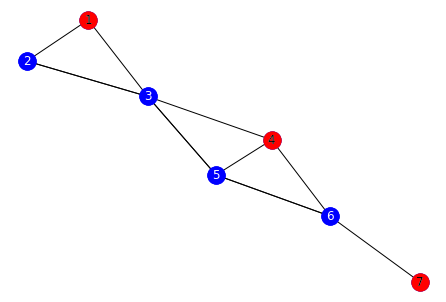

In [16]:
k = G.subgraph(solution2)
notS = list(set(G.nodes())-set(solution2))
othersubgraph = G.subgraph(notS)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(G,pos=pos,with_labels=True, node_color='b', font_color='w')
nx.draw(k,pos=pos,with_labels=True, node_color='r', font_color='k')
nx.draw(othersubgraph,pos=pos, node_color='b')
plt.show()

Check that the QUBO Q built above is the same as the qubo that was built in [independent_set.py](https://github.com/dwavesystems/dwave-networkx/blob/0b0bef77b04f4b383368e635ae1ffa5fcb75aeef/dwave_networkx/algorithms/independent_set.py):

In [17]:
weight=None
lagrange=2.0

In [18]:
cost = dict(G.nodes(data=weight, default=1))
scale = max(cost.values())
Q2 = {(node, node): min(-cost[node] / scale, 0.0) for node in G}
Q2.update({edge: lagrange for edge in G.edges})

In [19]:
Q2

{(1, 1): -1.0,
 (2, 2): -1.0,
 (3, 3): -1.0,
 (4, 4): -1.0,
 (5, 5): -1.0,
 (6, 6): -1.0,
 (7, 7): -1.0,
 (1, 2): 2.0,
 (1, 3): 2.0,
 (2, 3): 2.0,
 (3, 4): 2.0,
 (3, 5): 2.0,
 (4, 5): 2.0,
 (4, 6): 2.0,
 (5, 6): 2.0,
 (6, 7): 2.0}

In [20]:
Q == Q2

True

# 4. Solve maximum independent set

In [21]:
## import dwave_networkx for d-wave functions
import dwave_networkx as dnx

[dwave-networkx](https://github.com/dwavesystems/dwave-networkx/tree/0b0bef77b04f4b383368e635ae1ffa5fcb75aeef/dwave_networkx)

In [22]:
## Find the maximum independent set, S
S = dnx.maximum_independent_set(G, sampler=sampler, num_reads=10)

Maximum independent set size found is 3
[1, 5, 7]


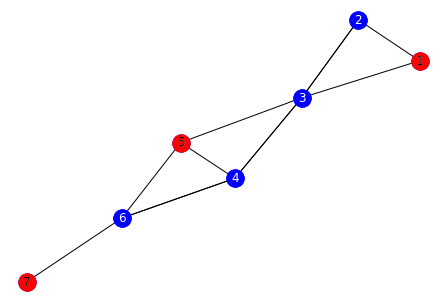

In [23]:
## Print the solution for the user
print('Maximum independent set size found is', len(S))
print(S)

## Visualize the results
#    Red nodes are in the set, blue nodes are not
k = G.subgraph(S)
notS = list(set(G.nodes())-set(S))
othersubgraph = G.subgraph(notS)
pos = nx.spring_layout(G)
plt.figure()
nx.draw(G,pos=pos,with_labels=True, node_color='b', font_color='w')
nx.draw(k,pos=pos,with_labels=True, node_color='r', font_color='k')
nx.draw(othersubgraph,pos=pos, node_color='b')
plt.show()

In [24]:
S

[1, 5, 7]